In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapz, cumtrapz
import os
from scipy.integrate import cumtrapz
from scipy.optimize import root_scalar, minimize_scalar, minimize
from scipy.stats import chi2

from constants import e_egb, err_high_egb, n_u_0, n_mw_pbhs
from diffuse_constraints import phi_ex
from frequentist_limits import diffuse_limit, point_source_limit
from distributions import Distribution_f, Distribution_N_gamma

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [11]:
m_dms = np.geomspace(1e1, 1e4, 3)
svs = np.geomspace(1e-44, 1e-23, 4)
dist_n_gamma = Distribution_N_gamma(m_pbh=0.5)
dist_n_gamma.save_p_gamma_table(m_dms, svs)

In [12]:
dist_n_gamma = Distribution_N_gamma(m_pbh=0.5, test=True)

In [15]:
sv, m_dm = 1e-35, 100.
dist_n_gamma.p_gamma(sv, m_dm), dist_n_gamma.p_gamma_err(sv, m_dm)

(array([5.44540144e-11]), array([6.62457273e-13]))

In [14]:
dist_n_gamma.cdf(n_gamma=19, sv=1e-35, f=1e-3, m_dm=100.)

0.9999975669978164

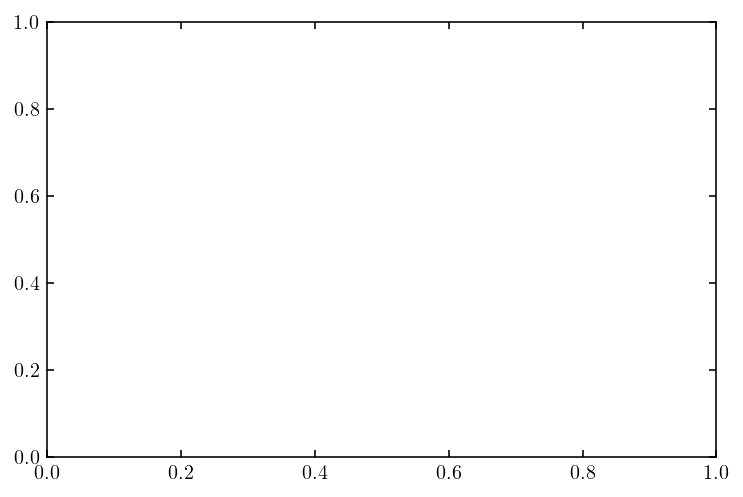

In [17]:
fig, axes = plt.subplots(1, 1)

In [18]:
axes

In [11]:
# Setup
n_pbhs = np.array([[1,  1,     10],
                   [80, 24000, 80]]).T
m_pbhs = np.array([[0.5, 10, 100],
                   [0.5, 10, 100]]).T
m_dms = np.logspace(1, 4, 30)

# Use 5th percentile for point-estimate for f
f_percentile = 0.05

# LIGO's prior ("J" or "LF")
merger_rate_prior = "J"

# BSM 95% contours
gambit_dir = "data/gambit/"
gambit_models = ["CMSSM", "MSSM7", "NUHM1", "NUHM2"]
n_gambit_grid_rows, n_gambit_grid_cols = 101, 203

# Colors
pbh_colors = {0.5: colors[0], 10: colors[1], 100: colors[2]}

def plot_gambit_contour_envelope(ax, color=None, padding=10, level=6):
    # TODO: Christoph said 3, not 6...
    # Construct parameter meshgrid
    m_dm_g = np.logspace(1, 4, n_gambit_grid_cols)[padding:]
    sv_g = np.logspace(-45, -23, n_gambit_grid_rows)[padding:]
    m_dm_g_mg, sv_g_mg = np.meshgrid(m_dm_g, sv_g)

    # Add the singlet contour separately
    singlet_contour = np.load(
            "{}contours_SingletDM.npy".format(gambit_dir)).T[padding:, padding:]
    ax.contourf(m_dm_g_mg, sv_g_mg, singlet_contour, levels=[0, level], alpha=0.2,
                colors=[color])
    
    # Construct envelope of other contours
    envelope = np.inf * np.ones([n_gambit_grid_rows - padding,
                                 n_gambit_grid_cols - padding])
    for model in gambit_models:
        gambit_contour = np.load(
            "{}contours_{}.npy".format(gambit_dir, model)).T[padding:, padding:]
        envelope = np.min([envelope, gambit_contour], axis=0)
    
    ax.contourf(m_dm_g_mg, sv_g_mg, envelope, levels=[0, level], alpha=0.35,
                colors=[color])

In [19]:
for k in {"a": 1, "b": 2}:
    print(k)

a
b


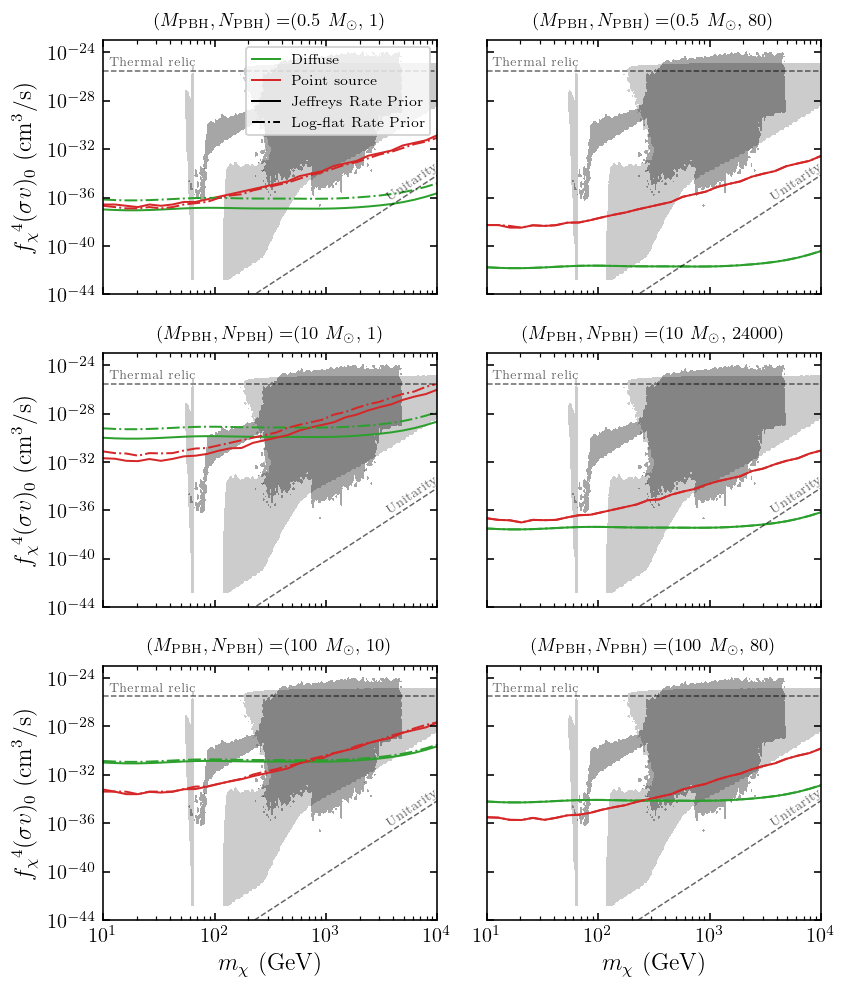

In [26]:
fig, axes = plt.subplots(n_pbhs.shape[0], n_pbhs.shape[1], sharex=True, sharey=True,
                         figsize=(6, 7))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        m_pbh = m_pbhs[i, j]
        n_pbh = n_pbhs[i, j]
        
        # Cross section limits
        # Different priors for merger rates
        for prior, ls in zip(["J", "LF"], ['-', '-.']):  # [["J", "-"]]:
            dist_f = Distribution_f(m_pbh, n_pbh, prior)
            f = dist_f.ppf(f_percentile)
            
            # Diffuse limit
            lab = "Diffuse" if prior == "J" else ""
            sv_diff_bounds = diffuse_limit(m_dms, m_pbh, n_pbh, f, prior)
            ax.loglog(m_dms, sv_diff_bounds, label=lab, linestyle=ls, color=colors[2])

            # Point source limit
            lab = "Point source" if prior == "J" else ""
            sv_ps_bounds = point_source_limit(m_dms, m_pbh, n_pbh, f, prior)
            ax.loglog(m_dms, sv_ps_bounds, label=lab, linestyle=ls, color=colors[3])
        
        # Other information
        # BSM physics contours
        plot_gambit_contour_envelope(ax, 'k')
        # Thermal relic cross section
        ax.text(1.12e1, 7e-26, "Thermal relic", alpha=0.6, fontsize=6)
        ax.axhline(3e-26, linestyle='--', color='k', alpha=0.6, linewidth=0.75)
        # Unitarity bound
        ax.loglog(m_dms, (m_dms / 1e3)**6 * 7e-41, '--k', alpha=0.6, linewidth=0.75)
        ax.text(6e3, 1.7e-35, "Unitarity", fontsize=6, rotation=34, alpha=0.6,
                horizontalalignment="center", verticalalignment="center")

        # Formatting
        ax.set_xlim(m_dms[[0, -1]])
        ax.set_ylim(1e-44, 1e-23)
        ax.set_title(r"$(M_{\mathrm{PBH}}, N_{\mathrm{PBH}}) = $" +
                     "({:g} $M_\odot$, {:d})".format(m_pbh, n_pbh), fontsize=9.0)
        if i == axes.shape[0] - 1:
            ax.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=12)
        if j == 0:
            ax.set_ylabel(r"$f_{\chi}{}^4 (\sigma v)_0$ (cm$^3$/s)", fontsize=12)
        if i == 0 and j == 0:
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-', label='Jeffreys Rate Prior')
            ax.plot([1e-50, 1e-50], [1e-50, 1e-50], color='k', linestyle='-.', label='Log-flat Rate Prior')
            ax.legend(fontsize=7)

fig.tight_layout()
fig.savefig("figures/frequentist_sv_limits_ps_diff_comparison.pdf",
            bbox_inches='tight', pad_inches=0.05)

In [ ]:
os.system("say 'done'")

# Scratch

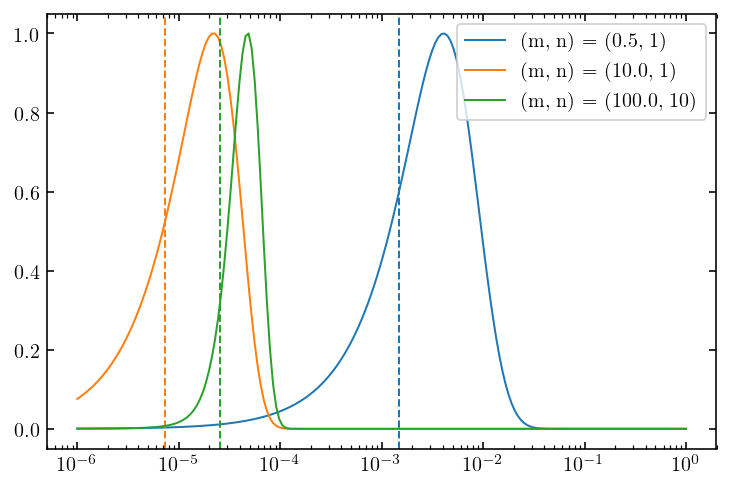

In [93]:
fs = np.geomspace(1e-6, 1e0, 200)
m_pbhs = np.array([0.5, 10, 100])
n_pbhs = np.array([1, 1, 10])

for m_pbh, n_pbh, c in zip(m_pbhs, n_pbhs, colors):
    p_f = Distribution_f(m_pbh, n_pbh, "LF")
    p_f_vals = p_f(fs)
    plt.plot(fs, p_f_vals / p_f_vals.max(), label="(m, n) = ({}, {})".format(p_f.m_pbh, p_f.n_pbh),
             color=c)
    plt.axvline(p_f.inverse_cdf(0.05), color=c, linestyle="--")

plt.xscale("log")
plt.legend()